# DEAPを使ってナップサック問題を解決する

## 概要
+ 遺伝的アルゴリズムモジュールであるDEAPを用いてナップサック問題を解くコードを書く
> http://deap.readthedocs.io/en/master/examples/ga_knapsack.html
> http://nobunaga.hatenablog.jp/entry/2016/05/16/121409

In [1]:
# 必要モジュールのインストール
!pip install deap

## モジュールのインポート

+ numpy:数値計算拡張モジュール
+ deap
    + algorithms: 遺伝的アルゴリズムの基本的なループ作業を扱う
    + base: 様々な関数などをDeapで扱うための土台となる
    + creator: 個体や適応度などを定義する
    + tools: GAに関わる様々な関数を扱う

In [2]:
import numpy as np
from deap import algorithms, base, creator, tools

## ナップサック問題とGAの設計

DEAPを使った遺伝的アルゴリズムで問題を解く流れは以下のようになります。

1. 問題の設計
    + 問題に必要なアイテムを作る
    + ナップサック問題なら今回の場合「重さ」と「価値」を持ったアイテムを作る
2. 適応度と個体の設定
    + 遺伝子に対して最大化or最小化問題を設計する
3. GAに必要な関数の設計
    + 評価・交叉・突然変異の関数を設計する
    + 自作も可能だが、既にtools内に準備されている関数もある
4. GAの各関数をDeapで実行できるように統一する
    + toolboxクラスを使ってそれぞれの関数をdeapで使えるように統一する
5. GAで計算
6. 計算結果を可視化
    + 結果が世代ごとにどのように推移していったかを可視化する

### 1. ナップサック問題を設計

In [3]:
# 必要変数の設計
NBR_ITEMS = 10 # 荷物の種類の数
MAX_WEIGHT = 20 # バッグの容量

In [4]:
# seed値を固定することで再現性を確保
np.random.seed(98)

items = {}
for i in range(NBR_ITEMS):
    items[i] = (np.random.randint(1,20), np.random.randint(0, 10))

In [5]:
# 生成されたitemには大きさと重さが含まれている
items.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [6]:
items.values()

dict_values([(11, 4), (2, 4), (8, 6), (10, 2), (3, 9), (10, 5), (3, 9), (4, 7), (5, 6), (10, 2)])

### 2. 適応度と個体の設定
+ DEAPでは個体表現や適応度をクラスとして定義するしており、Fitnessで定義しているweightsは最小化or最大化問題を定義している。
+ 今回はOneMax問題を使って遺伝的アルゴリズムにアプローチするので遺伝子のリストが最大になるように最適化する。
    + リストがすべて1になる(すべての荷物が入る)ように最適化   
+ ただし上記だけを最適化すると問題を解いたことにはならないため条件を付与する。
    + ナップサック問題の場合
        + 総重量 -> 小さくしたい
        + 総価値 -> 大きくしたい

In [7]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", np.ndarray, fitness=creator.FitnessMax)

### 3. GAに必要な交叉や突然変異関数の作成
交叉方法や突然変異方法は自作もできるし、モジュールで準備されている関数を使用することもできる。

+ ドキュメント
> http://deap.readthedocs.io/en/master/api/tools.html

#### 評価関数
評価の際には実際にナップサックの容量と重量が条件を満たしているかを測る

In [8]:
def evalOneMax(individual):
    weight, value = 0, 0
    for idx, i in enumerate(individual):
        if i == 1:
            weight += items[idx][0]
            value += items[idx][1]
    if weight > MAX_WEIGHT:
        return 0,
    return value,

#### 交叉関数
交叉は2点交叉を使用するものとする。DEAPでは `tools.cxTwoPoint`で実装されている。

#### 突然変異関数
突然変異は0,1で表されるビットを反転させるものを使用する。DEAPでは `tools.mutFlipBit` で実装されている。

### 4. GAの関数をDeapのインターフェースに統一

random.randintはa~bまでを参照するけど、np.random.randintはa~b-1を参照するので注意！
> https://qiita.com/hamukazu/items/ec1b4659df00f0ce43b1

In [9]:
toolbox = base.Toolbox()
toolbox.register("attr_bool", np.random.randint, 0, 2)
toolbox.register("individual", tools.initRepeat, creator.Individual, 
    toolbox.attr_bool, NBR_ITEMS)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [10]:
toolbox.register("evaluate", evalOneMax)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.5)
toolbox.register("select", tools.selTournament, tournsize=3)

### 5. GAを計算する

In [11]:
def main(NGEN, MU, LABMDA, CXPB, MUTPB, VERBOSE):
    np.random.seed(98)
    
    pop = toolbox.population(n=MU)
    
    hof = tools.HallOfFame(1, similar=np.array_equal)
    logbook = tools.Logbook()
    
    # 価値がどのように推移したかを記録
    stats_fit = tools.Statistics(key=lambda ind: ind.fitness.values[0])
    # 荷物の数がどのように推移したかを記録
    stats_size = tools.Statistics(key=lambda ind: len([i for i in ind if i==1]))
    
    mstats = tools.MultiStatistics(values=stats_fit, num_of_item=stats_size)
    
    mstats.register("avg", np.mean, axis=0)
    #mstats.register("std", np.std, axis=0)
    mstats.register("min", np.min, axis=0)
    mstats.register("max", np.max, axis=0)
    
    pop, logbook = algorithms.eaMuPlusLambda(pop, 
                                             toolbox, 
                                             MU, 
                                             LAMBDA, 
                                             CXPB, 
                                             MUTPB, 
                                             NGEN, 
                                             mstats, 
                                             halloffame=hof,
                                            verbose=VERBOSE)
    
    return pop, mstats, hof, logbook

ここで設定する値を変更することで交叉や突然変異の確率を変更することができる。

+ NGEN:世代数
+ MU:エリート選択の数。0にすると選択しない
+ LAMBDA:各世代で生む子供の数。0にすると子供が生まれない。
+ CXPB:交配によって生まれる子供の確率。0だと子供が生まれても残らない。
+ MUTPB:突然変異によって生まれる子供の確率。0だと子供が生まれても残らない。

In [12]:
NGEN = 50
MU = 100
LAMBDA = 30
CXPB = 0.7 # LAMBDA * CXPB 分の個体が生まれる
MUTPB = 0.2

In [13]:
# 世代ごとの結果が出力される
# gen -> 世代
# nevals -> 評価された個体数
pop, mstats, hof, logbook = main(NGEN, MU, LAMBDA, CXPB, MUTPB, True)

   	      	    num_of_item    	       values      
   	      	-------------------	-------------------
gen	nevals	avg 	max	min	avg 	max	min
0  	100   	5.42	9  	2  	0.98	26 	0  
1  	28    	5.16	9  	2  	3.65	26 	0  
2  	28    	4.36	9  	2  	8.42	26 	0  
3  	29    	3.54	9  	1  	16.93	26 	0  
4  	28    	3.54	4  	2  	23.71	31 	11 
5  	26    	3.92	4  	2  	26.64	31 	16 
6  	26    	4.01	5  	4  	28.03	35 	26 
7  	27    	4.07	5  	4  	29.46	35 	26 
8  	25    	4.26	5  	4  	31.73	35 	28 
9  	24    	4.68	5  	4  	33.72	35 	31 
10 	29    	4.96	5  	4  	34.84	35 	31 
11 	27    	5   	5  	5  	35   	35 	35 
12 	27    	5   	5  	5  	35   	35 	35 
13 	30    	5   	5  	5  	35   	35 	35 
14 	26    	5   	5  	5  	35   	35 	35 
15 	29    	5   	5  	5  	35   	35 	35 
16 	26    	5   	5  	5  	35   	35 	35 
17 	27    	5   	5  	5  	35   	35 	35 
18 	28    	5   	5  	5  	35   	35 	35 
19 	26    	5   	5  	5  	35   	35 	35 
20 	21    	5   	5  	5  	35   	35 	35 
21 	27    	5   	5  	5  	35   	35 	35 
22 	27    	5   	5  	5  	35  

In [14]:
hof.items[0]

Individual([0, 1, 1, 0, 1, 0, 1, 1, 0, 0])

In [15]:
# 選択された荷物
result = [items[i] for i, h in enumerate(hof.items[0]) if h==1]
result

[(2, 4), (8, 6), (3, 9), (3, 9), (4, 7)]

In [16]:
def calResult(individual):
    weight, value = 0, 0
    for idx, i in enumerate(individual):
        if i == 1:
            weight += items[idx][0]
            value += items[idx][1]
    return weight, value

In [17]:
weights, values = calResult(hof.items[0])
print("荷物の総重量 => {0}\n荷物の総価値 => {1}".format(weights, values))

荷物の総重量 => 20
荷物の総価値 => 35


### 6. 出力結果の可視化

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

In [19]:
logbook.header = "gen", "evals", "num_of_items", "values"
logbook.chapters["num_of_items"].header = "min", "avg", "max"
logbook.chapters["values"].header = "min", "avg", "max"

max_values = logbook.chapters["values"].select("max")

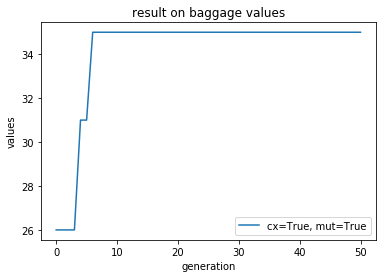

In [20]:
plt.title("result on baggage values")
plt.xlabel("generation")
plt.ylabel("values")
plt.plot(max_values, label="cx={}, mut={}".format(True, True))
plt.legend()

## ステップアップ：交叉や突然変異のパラメータを変更して学習過程を見ていこう

上記の交叉や突然変異のパラメータを変更しながらGAの関数の役割を見ていく。

+ 完全ランダム: LAMBDA,CXPB, MUTPBは0にする
+ **選択のみ**: CXPB,MUTPBは0にする
    + 選択をしない方法は(そもそもGAとしてだめ)なのでparam_optには未実装
        + 交叉のみ: LAMBDA, MUTPBは0にする
        + 突然変異のみ: LAMBDA,CXPBは0にする
+ **選択+交叉**: MUTPBは0にする
+ **選択+突然変異**: CXPBは0にする

In [28]:
def param_opt(cx, mut) -> bool:
    # パラメータの設定
    NGEN = 50
    MU = 100
    LAMBDA = 30
    CXPB = 0.7 # LAMBDA * CXPB 分の個体が生まれる
    MUTPB = 0.2
    
    if cx == mut == False:
        CXPB, MUTPB = 0.0, 0.0
    elif cx == False:
        CXPB = 0.0
        MUTPB = 1.0
    elif mut == False:
        CXPB = 1.0
        MUTPB = 0.0    
    
    return NGEN, MU, LAMBDA, CXPB, MUTPB

In [29]:
param_opt(True, True)

(50, 100, 30, 0.7, 0.2)

In [30]:
def compare_plot(cx_flag, mut_flag):
    NGEN, MU, LAMBDA, CXPB, MUTPB = param_opt(cx_flag, mut_flag)
    pop, mstats, hof, logbook = main(NGEN, MU, LAMBDA, CXPB, MUTPB, False)

    logbook.header = "gen", "evals", "num_of_items", "values"
    logbook.chapters["num_of_items"].header = "min", "avg", "max"
    logbook.chapters["values"].header = "min", "avg", "max"
    
    # generation ごとの値のリストを取得
    max_values = logbook.chapters["values"].select("max")
    
    return max_values

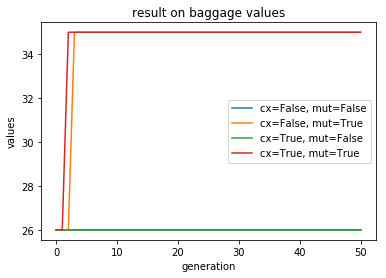

In [31]:
flags = [[False, False], [False, True], [True, False], [True, True]]

plt.title("result on baggage values")
plt.xlabel("generation")
plt.ylabel("values")

for flag in flags:
    max_values = compare_plot(flag[0], flag[1])
    plt.plot(max_values, label="cx={}, mut={}".format(flag[0], flag[1]))
plt.legend()
#plt.plot(max_picks)